# Automatice Liver & Lesion Segmentation on 3DIRCAD1 Dataset


### Loading Caffe Prototxt and Model for Step 1 and Step 2

In [1]:
STEP1_DEPLOY_PROTOTXT = "/Cascaded-FCN/models/cascadedfcn/step1/step1_deploy.prototxt"
STEP1_MODEL_WEIGHTS   = "/data/step1_weights.caffemodel"
STEP2_DEPLOY_PROTOTXT = "/Cascaded-FCN/models/cascadedfcn/step2/step2_deploy.prototxt"
STEP2_MODEL_WEIGHTS   = "/data/step2_weights.caffemodel"

In [12]:
import caffe
caffe.set_mode_gpu()
import scipy as sp
import scipy.misc, scipy.ndimage.interpolation
from denseinference import CRFProcessor
from medpy import metric
import numpy as np

#### Method for scaling and normalizing slice of Volume

In [13]:
def to_scale(img, shape=None):
    if shape is None:
        shape = config.slice_shape

    height, width = shape
    if img.dtype == SEG_DTYPE:
        return scipy.misc.imresize(img,(height,width),interp="nearest").astype(SEG_DTYPE)
    elif img.dtype == IMG_DTYPE:
        max_ = np.max(img)
        factor = 256.0/max_ if max_ != 0 else 1
        return (scipy.misc.imresize(img,(height,width),interp="nearest")/factor).astype(IMG_DTYPE)
    else:
        raise TypeError('Error. To scale the image array, its type must be np.uint8 or np.float64. (' + str(img.dtype) + ')')

def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

#### Method for Histogram Equalisation

In [14]:
def histeq_processor(img):
    """Histogram equalization"""
    nbr_bins=256
    #get image histogram
    imhist,bins = np.histogram(img.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() #cumulative distribution function
    cdf = 255 * cdf / cdf[-1] #normalize
    #use linear interpolation of cdf to find new pixel values
    original_shape = img.shape
    img = np.interp(img.flatten(),bins[:-1],cdf)
    img=img/255.0
    return img.reshape(original_shape)

#### Method to plot multiple slice using matplot

In [20]:
from matplotlib import pyplot as plt
from IPython import display
plt.set_cmap('gray')
%matplotlib inline
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()


In [49]:
def print_minmax(img, message):
    pass

In [54]:
from saratan_utils import norm_hounsfield_stat,norm_hounsfield_dyn
ct_window_type=''
ct_window_type_min=-100
ct_window_type_max=200
IMG_DTYPE = np.float
SEG_DTYPE = np.uint8
slice_shape = (388,388)
apply_histeq = False
def downscale_img_label(imgvol,label_vol):
    """
    Downscales an image volume and an label volume. Normalizes the hounsfield units of the image volume
    :param imgvol:
    :param label_vol:
    :return:
    """
    imgvol = imgvol.astype(IMG_DTYPE)
    label_vol = label_vol.astype(SEG_DTYPE)

    imgvol_downscaled = np.zeros((slice_shape[0],slice_shape[1],imgvol.shape[2]))
    label_vol_downscaled = np.zeros((slice_shape[0],slice_shape[1],imgvol.shape[2]))

    # Copy image volume
    #copy_imgvol = np.copy(imgvol)
    #Truncate metal and high absorbative objects
    imgvol[imgvol>1200] = 0

    for i in range(imgvol.shape[2]):
        #Get the current slc, normalize and downscale
        slc = imgvol[:,:,i]

        print_minmax(slc, "stage1")

        slc = np.clip(slc, -100, 400)
        print_minmax(slc, "stage1.5 - after clip")
        slc = normalize_image(slc)
        print_minmax(slc, "stage2 - after norm")
        #slc = norm_hounsfield_dyn(slc)

        slc = to_scale(slc, slice_shape)

        if apply_histeq:
            slc = histeq_processor(slc)


        print_minmax(slc, "stage3 - after to_scale-histeq")
        imgvol_downscaled[:,:,i] = slc

        #downscale the label slc for the crf
        label_vol_downscaled[:,:,i] = to_scale(label_vol[:,:,i] ,slice_shape)

    return [imgvol_downscaled,label_vol_downscaled]

In [55]:
import dicom
import natsort
import glob, os
import re
def read_dicom_series(directory, filepattern = "image_*"):
    """ Reads a DICOM Series files in the given directory. 
    Only filesnames matching filepattern will be considered"""
    
    if not os.path.exists(directory) or not os.path.isdir(directory):
        raise ValueError("Given directory does not exist or is a file : "+str(directory))
    print '\tRead Dicom',directory
    lstFilesDCM = natsort.natsorted(glob.glob(os.path.join(directory, filepattern)))
    print '\tLength dicom series',len(lstFilesDCM)
    # Get ref file
    RefDs = dicom.read_file(lstFilesDCM[0])
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = dicom.read_file(filenameDCM)
        # store the raw image data
        ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

    return ArrayDicom

def read_liver_lesion_masks(masks_dirname):
    """Since 3DIRCAD provides an individual mask for each tissue type (in DICOM series format),
    we merge multiple tissue types into one Tumor mask, and merge this mask with the liver mask
    
    Args:
        masks_dirname : MASKS_DICOM directory containing multiple DICOM series directories, 
                        one for each labelled mask
    Returns:
        numpy array with 0's for background pixels, 1's for liver pixels and 2's for tumor pixels
    """
    tumor_volume = None
    liver_volume = None
    
    # For each relevant organ in the current volume
    for organ in os.listdir(masks_dirname):
        organ_path = os.path.join(masks_dirname,organ)
        if not os.path.isdir(organ_path):
            continue
        
        organ = organ.lower()
        
        if organ.startswith("livertumor") or re.match("liver.yst.*", organ) or organ.startswith("stone") or organ.startswith("metastasecto") :
            print 'Organ',masks_dirname,organ
            current_tumor = read_dicom_series(organ_path)
            current_tumor = np.clip(current_tumor,0,1)
            # Merge different tumor masks into a single mask volume
            tumor_volume = current_tumor if tumor_volume is None else np.logical_or(tumor_volume,current_tumor)
        elif organ == 'liver':
            print 'Organ',masks_dirname,organ
            liver_volume = read_dicom_series(organ_path)
            liver_volume = np.clip(liver_volume, 0, 1)
    
    # Merge liver and tumor into 1 volume with background=0, liver=1, tumor=2
    label_volume = np.zeros(liver_volume.shape)
    label_volume[liver_volume==1]=1
    label_volume[tumor_volume==1]=2
    return label_volume    

In [91]:
def zoomliver_UNET_processor(img, seg):
    """ Custom preprocessing of img,seg for UNET architecture:
    Crops the background and upsamples the found patch."""

    # Remove background !
    img = np.multiply(img,np.clip(seg,0,1))
    # get patch size
    col_maxes = np.max(seg, axis=0) # a row
    row_maxes = np.max(seg, axis=1)# a column

    nonzero_colmaxes = np.nonzero(col_maxes)[0]
    nonzero_rowmaxes = np.nonzero(row_maxes)[0]

    x1, x2 = nonzero_colmaxes[0], nonzero_colmaxes[-1]
    y1, y2 = nonzero_rowmaxes[0], nonzero_rowmaxes[-1]
    width = x2-x1
    height= y2-y1
    MIN_WIDTH = 60
    MIN_HEIGHT= 60
    x_pad = (MIN_WIDTH - width) / 2 if width < MIN_WIDTH else 0
    y_pad = (MIN_HEIGHT - height)/2 if height < MIN_HEIGHT else 0

    x1 = max(0, x1-x_pad)
    x2 = min(img.shape[1], x2+x_pad)
    y1 = max(0, y1-y_pad)
    y2 = min(img.shape[0], y2+y_pad)

    img = img[y1:y2+1, x1:x2+1]
    seg = seg[y1:y2+1, x1:x2+1]

    img = to_scale(img, (388,388))
    seg = to_scale(seg, (388,388))
    # All non-lesion is background
    seg[seg==1]=0
    #Lesion label becomes 1
    seg[seg==2]=1

    # Now do padding for UNET, which takes 572x572
    #seg=np.pad(seg,((92,92),(92,92)),mode='reflect')
    img=np.pad(img,92,mode='reflect')
    return img, (x1,x2,y1,y2)


In [92]:
from surface import Surface


def get_scores(pred,label,vxlspacing):
    volscores = {}

    volscores['dice'] = metric.dc(pred,label)
    volscores['jaccard'] = metric.binary.jc(pred,label)
    volscores['voe'] = 1. - volscores['jaccard']
    volscores['rvd'] = metric.ravd(label,pred)

    if np.count_nonzero(pred) ==0 or np.count_nonzero(label)==0:
        volscores['assd'] = 0
        volscores['msd'] = 0
    else:
        evalsurf = Surface(pred,label,physical_voxel_spacing = vxlspacing,mask_offset = [0.,0.,0.], reference_offset = [0.,0.,0.])
        volscores['assd'] = evalsurf.get_average_symmetric_surface_distance()

        volscores['msd'] = metric.hd(label,pred,voxelspacing=vxlspacing)

    return volscores


### Main method for evaluating 3DIRCAD1 with 3-fold validation

In [127]:
net1_n_classes = 2
apply_liver_crf=True
def validation(volid,patient_dir,voxelspacing):
    image_folder=patient_dir+"/PATIENT_DICOM"
    seg_folder=patient_dir+"/MASKS_DICOM"
    imgvol=read_dicom_series(image_folder)
    labelvol=read_liver_lesion_masks(seg_folder)
    img_vol_downscaled,lbl_vol_downscaled=downscale_img_label(imgvol,labelvol)
    print img_vol_downscaled.shape,lbl_vol_downscaled.shape
   
    print "prepro ", np.max(img_vol_downscaled)
    probvol = np.zeros((slice_shape[0],slice_shape[1],
                    img_vol_downscaled.shape[2],net1_n_classes))
    pred_step_two = np.zeros((slice_shape[0],slice_shape[1],img_vol_downscaled.shape[2]))
    probvol_step_two = np.zeros((slice_shape[0],slice_shape[1],img_vol_downscaled.shape[2],2))
    print "Running Step 1"
    #np.save(os.path.join(outdir,"input_"+str(volid)), imgvol_downscaled)
    net1=caffe.Net(STEP1_DEPLOY_PROTOTXT,STEP1_MODEL_WEIGHTS,caffe.TEST)
    for i in range(img_vol_downscaled.shape[2]):
        slc = img_vol_downscaled[:,:,i]
        #create mirrored slc for unet
        slc = np.pad(slc,((92,92),(92,92)),mode='reflect')

        #load slc into network and do forward pass
        net1.blobs['data'].data[...] = slc
        net1.forward()
        #now save raw probabilities
        # Net output: Slc x C x W x H
        netprob = net1.blobs['prob'].data
        probvol[:,:,i,:]  = netprob.transpose((0,2,3,1))[0]
    if apply_liver_crf:
        print "Running CRF"
        crfparams = {'max_iterations': 10 ,
                    'dynamic_z': True ,
                    'ignore_memory': True ,
                    'bilateral_x_std': 9.0,'bilateral_y_std': 9.0,'bilateral_z_std': 9.0,
                    'pos_x_std': 1.5 ,'pos_y_std': 1.5,'pos_z_std': 1.5,
                    'bilateral_intensity_std': 20.0,'bilateral_w': 10.0,
                    'pos_w': 3.0 }
        pro = CRFProcessor.CRF3DProcessor(**crfparams)
        print np.max(img_vol_downscaled), np.min(img_vol_downscaled)
        liver_pred = pro.set_data_and_run(img_vol_downscaled, probvol)
        #np.save("liver_crf_"+str(volid), liver_pred)
    else:
        print probvol.shape
        liver_pred = np.argmax(probvol,axis=3).astype(SEG_DTYPE)
        print liver_pred.shape

    
    del net1
    print "Running Step 2"
    net2=caffe.Net(STEP2_DEPLOY_PROTOTXT,STEP2_MODEL_WEIGHTS,caffe.TEST)
    for i in range(img_vol_downscaled.shape[2]):
        slc = img_vol_downscaled[:,:,i]

        #now we crop and upscale the liver
        slc_pred_liver = liver_pred[:, :, i].astype(SEG_DTYPE)

        if np.count_nonzero(slc_pred_liver) == 0:
            probvol_step_two[:,:,i,:] = 0
        else:
            slc, bbox = zoomliver_UNET_processor(slc, slc_pred_liver)
            #load slc into network and do forward pass
            net2.blobs['data'].data[...] = slc
            net2.forward()

            #scale output back down and insert into the probability volume

            x1,x2,y1,y2 = bbox
            leftpad, rightpad = x1, 388-x2
            toppad, bottompad = y1, 388-y2
            width, height = int(x2-x1), int(y2-y1)
            #now save probabilities
            prob = net2.blobs['prob'].data.transpose((0,2,3,1))[0]
            slc_pred_step_two = np.argmax(prob,axis=2).astype(SEG_DTYPE)

            slc_pred_step_two = to_scale(slc_pred_step_two, (height,width))
            slc_pred_step_two = np.pad(slc_pred_step_two, ((toppad,bottompad),(leftpad,rightpad)), mode='constant')
            pred_step_two[:,:,i] = slc_pred_step_two
    liver_pred[pred_step_two==1] = 2

    pred = liver_pred.astype(int)
    label = lbl_vol_downscaled.astype(int)

    liver_scores = get_scores(pred>=1,label>=1,voxelspacing)
    lesion_scores= get_scores(pred==2,label==2,voxelspacing)
    print "Liver dice for volid:",volid,liver_scores['dice'], "Lesion dice for volid",volid, lesion_scores['dice']
    return [volid,liver_scores,lesion_scores]

    

	Read Dicom /data/3Dircadb1/3Dircadb1.1/PATIENT_DICOM
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM liverkyst
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/liverkyst
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor01
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor01
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor04
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor04
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor06
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor06
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor02
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor02
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor03
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor03
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1

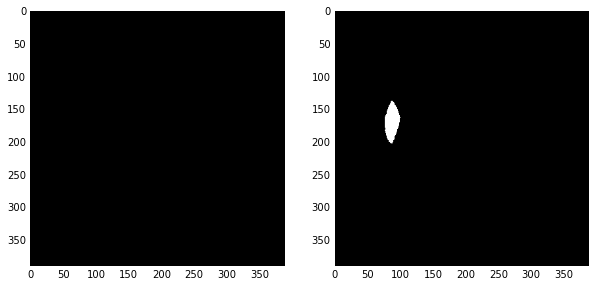

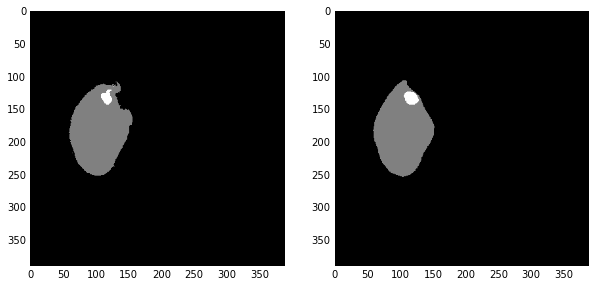

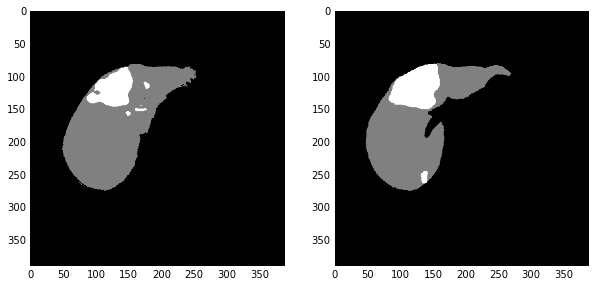

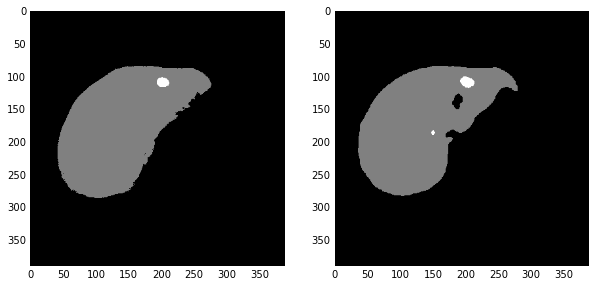

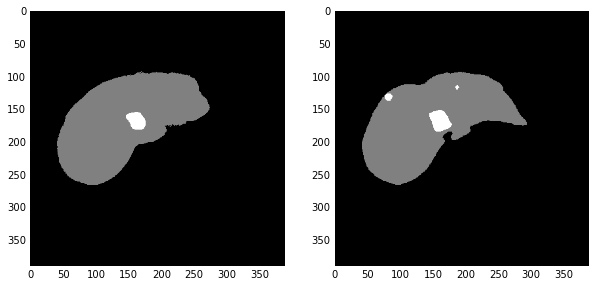

Liver dice 0.940870833442 Lesion dice 0.673483498032
[{'voe': 0.11165619534500604, 'dice': 0.9408708334415798, 'rvd': 0.011667668344096554, 'assd': 1.7381469482359235, 'jaccard': 0.888343804654994, 'msd': 27.086860283170509}, {'voe': 0.4922916548476769, 'dice': 0.6734834980316164, 'rvd': -0.2727051158105111, 'assd': 7.2081406585250578, 'jaccard': 0.5077083451523231, 'msd': 53.093940332207403}]


In [115]:
voxel_spacing= [([0.57,0.57,1.6]),([0.78,0.78,1.6]),([0.62,0.62,1.25]),([0.74,0.74,2.]),
([0.78,0.78,1.6]),([0.78,0.78,1.6]),([0.78,0.78,1.6]),
([0.56,0.56,1.6]),([0.87,0.87,2.]),([0.73,0.73,1.6]),([0.72,0.72,1.6]),([0.68,0.68,1.]),
                ([0.67,0.67,1.6]),([0.72,0.72,1.6]),([0.78,0.78,1.6]),
([0.7,0.7,1.6]),([0.74,0.74,1.6]),([0.74,0.74,2.5]),([0.7,0.7,4.]),([0.81,0.81,2.])]
scores=validation("3Dircadb1.1",voxel_spacing[0])
print scores

In [131]:
IRCA_BASE_PATH="/data/3Dircadb1/"
irca_all= [\
(301,IRCA_BASE_PATH+"3Dircadb1.1",[0.57,0.57,1.6]),
(302,IRCA_BASE_PATH+"3Dircadb1.2",[0.78,0.78,1.6]),
(303,IRCA_BASE_PATH+"3Dircadb1.3",[0.62,0.62,1.25]),
(304,IRCA_BASE_PATH+"3Dircadb1.4",[0.74,0.74,2.]),
#(305,IRCA_BASE_PATH+"3Dircadb1.5",[0.78,0.78,1.6]),
(306,IRCA_BASE_PATH+"3Dircadb1.6",[0.78,0.78,1.6]),
#(307,IRCA_BASE_PATH+"image07.nii",[0.78,0.78,1.6]),
(308,IRCA_BASE_PATH+"3Dircadb1.8",[0.56,0.56,1.6]),
(309,IRCA_BASE_PATH+"3Dircadb1.9",[0.87,0.87,2.]),
(310,IRCA_BASE_PATH+"3Dircadb1.10",[0.73,0.73,1.6]),
#(311,IRCA_BASE_PATH+"3Dircadb1.11",[0.72,0.72,1.6]),
(312,IRCA_BASE_PATH+"3Dircadb1.12",[0.68,0.68,1.]),
(313,IRCA_BASE_PATH+"3Dircadb1.13",[0.67,0.67,1.6]),
#(314,IRCA_BASE_PATH+"3Dircadb1.14",[0.72,0.72,1.6]),
(315,IRCA_BASE_PATH+"3Dircadb1.15",[0.78,0.78,1.6]),
(316,IRCA_BASE_PATH+"3Dircadb1.16",[0.7,0.7,1.6]),
(317,IRCA_BASE_PATH+"3Dircadb1.17",[0.74,0.74,1.6]),
(318,IRCA_BASE_PATH+"3Dircadb1.18",[0.74,0.74,2.5]),
(319,IRCA_BASE_PATH+"3Dircadb1.19",[0.7,0.7,4.])]

In [132]:
### 3 Fold
irca_test_fold1 = irca_all[:5]
irca_train_fold1 = irca_all[5:]

irca_test_fold2 = irca_all[5:10]
irca_train_fold2 = irca_all[:5] + irca_all[10:]

irca_test_fold3 = irca_all[10:15]
irca_train_fold3 = irca_all[:10]
irca_dataset = [irca_test_fold1, irca_test_fold2, irca_test_fold3]
#print len(irca_dataset[1])

### Method to calculate Overall score for each fold

In [133]:
overall_score= []
for i in range(len(irca_dataset)):
    foldscore = []
    print 'Starting fold',i+1
    for j in range(len(irca_dataset[i])):
       
        volid_liver_lesion_score=validation(volid=irca_dataset[i][j][0],patient_dir=irca_dataset[i][j][1],
                                           voxelspacing=irca_dataset[i][j][2])
        foldscore.append(volid_liver_lesion_score)
    overall_score.append(foldscore)
    print 'Completed fold',i+1

Starting fold 1
	Read Dicom /data/3Dircadb1/3Dircadb1.1/PATIENT_DICOM
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM liverkyst
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/liverkyst
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor01
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor01
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor04
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor04
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor06
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor06
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor02
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor02
	Length dicom series 129
Organ /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM livertumor03
	Read Dicom /data/3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor03
	Length dicom series 129
Organ /data/3Dirc

In [134]:
print overall_score

[[[301, {'voe': 0.11165619534500604, 'dice': 0.9408708334415798, 'rvd': 0.011667668344096554, 'assd': 1.7381469482359235, 'jaccard': 0.888343804654994, 'msd': 27.086860283170509}, {'voe': 0.4922916548476769, 'dice': 0.6734834980316164, 'rvd': -0.2727051158105111, 'assd': 7.2081406585250578, 'jaccard': 0.5077083451523231, 'msd': 53.093940332207403}], [302, {'voe': 0.17740029073399421, 'dice': 0.9026663453131809, 'rvd': -0.05725419981101643, 'assd': 2.6568669021085554, 'jaccard': 0.8225997092660058, 'msd': 33.78499667011971}, {'voe': 0.9909883203889251, 'dice': 0.017862389094541395, 'rvd': 0.11284916201117319, 'assd': 41.180841162694655, 'jaccard': 0.00901167961107488, 'msd': 131.44554157520903}], [303, {'voe': 0.12134308626601509, 'dice': 0.9354096613495885, 'rvd': -0.025635479826677323, 'assd': 1.4422044626205952, 'jaccard': 0.8786569137339849, 'msd': 15.025604813118173}, {'voe': 0.9944030524427968, 'dice': 0.011131592176764895, 'rvd': 8.136617325891773, 'assd': 34.393393395854844, 'ja

### Method to get avearge score for each scorename in a fold

In [192]:
def get_average_score_liver(scorelist,scorename,mode=None):
    """
    :param scorelist:
    :param scorename:
    :return:
    """

    score = 0.
    for i in range(len(scorelist)):
#         for item in e[1]: 
        if mode=='abs':
            core += np.abs(scorelist[i][1][scorename])
        else:
            score += scorelist[i][1][scorename]
    score /= float(len(scorelist))

    return score

In [204]:
def get_average_score_lesion(scorelist,scorename,mode=None):
    """
    :param scorelist:
    :param scorename:
    :return:
    """

    score = 0.
    count=0
    for i in range(len(scorelist)):
#         for item in e[1]: 
        if mode=='abs':
            core += np.abs(scorelist[i][2][scorename])
        else:
            if(scorelist[i][2][scorename]<0.1):
                count=count+1
            score += scorelist[i][2][scorename]
    #print len(scorelist)-count
    score /= float(len(scorelist)-count)

    return score

In [209]:
fold_score_dice=[]
for i in range(len(overall_score)):
    print "Average Liver Scores after CRF for fold ",i+1,":",get_average_score_liver(overall_score[i],'dice')
    fold_score_dice.append(get_average_score_liver(overall_score[i],'dice'))
print fold_score_dice

Average Liver Scores after CRF for fold  1 : 0.920273764187
Average Liver Scores after CRF for fold  2 : 0.892035290764
Average Liver Scores after CRF for fold  3 : 0.890233785339
[0.9202737641873975, 0.8920352907643189, 0.8902337853393941]


In [205]:
fold_score_lesion=[]
for i in range(len(overall_score)):
    print "Average Lesion Scores for fold ",i+1,":",get_average_score_lesion(overall_score[i],'dice')
    fold_score_lesion.append(get_average_score_lesion(overall_score[i],'dice'))
    

Average Lesion Scores after CRF for fold  1 : 0.61175641549
Average Lesion Scores after CRF for fold  2 : 0.566226419082
Average Lesion Scores after CRF for fold  3 : 0.544772065043
